# LDDMM: how to estimate a deterministic atlas?

This is analog to a registration problem for multiple meshes.

For registration between two meshes check [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb) and [LDDMM: how to visualize registration results?](./lddmm_register_mesh_template_viz.ipynb). 

In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing import (
    Map,
    PartiallyInitializedStep,
)
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.io import PvReader, PvWriter
from polpo.preprocessing.mesh.registration import PvAlign

No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
VIZ = False
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
OUTPUTS_DIR = Path("results") / "atlas_example"
ATLAS_DIR = OUTPUTS_DIR / "atlas"

OUTPUTS_DIR.mkdir(exist_ok=True)

## Loading meshes

In [4]:
subject_id = "01"

file_finder = DenseMaternalMeshLoader(
    subject_id=subject_id,
    subset=[1, 2, 3],
    as_dict=False,
    left=True,
    struct="Hipp",
)

pipe = file_finder + Map(PvReader())

meshes = pipe()

In [5]:
if VIZ:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh, show_edges=True)

    pl.show()

In [6]:
prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[0],
    max_iterations=500,
)

meshes = prep_pipe(meshes)

In [7]:
if VIZ:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh, show_edges=True)

    pl.show()

## LDDMM

Save meshes in `vtk` format (as required by `deformetrica`).

In [8]:
meshes_writer = Map(PvWriter(dirname=OUTPUTS_DIR, ext="vtk"))

dataset = meshes_writer([(f"mesh_{index}", mesh) for index, mesh in enumerate(meshes)])

Use LDDMM to estimate the atlas.

In [9]:
kernel_width = 10.0  # NB: influences the number of cp
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
)


plddmm.estimate_deterministic_atlas(
    source=dataset[0],  # TODO: why do we need a source?
    targets=dataset,
    output_dir=ATLAS_DIR,
    initial_step_size=1e-1,
    **registration_kwargs,
)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlas_example/atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_meth

Visualize the results.

In [10]:
cp, momenta = plddmm.io.load_cp_and_momenta(ATLAS_DIR)
template = plddmm.io.load_template(ATLAS_DIR, as_pv=True)

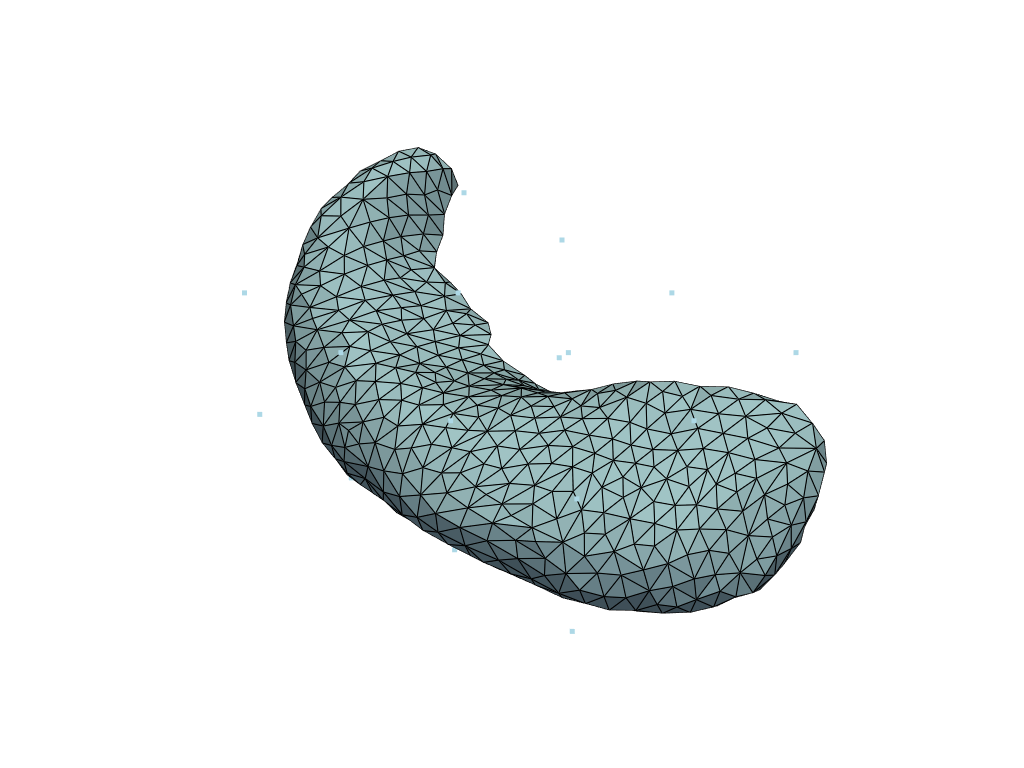

In [11]:
pl = pv.Plotter()

pl.add_mesh(template, show_edges=True)

pl.add_mesh(pv.PolyData(cp))

pl.show()

Visualize the reconstruction errors.

In [12]:
rec_meshes = plddmm.io.load_deterministic_atlas_reconstructions(ATLAS_DIR, as_pv=True)

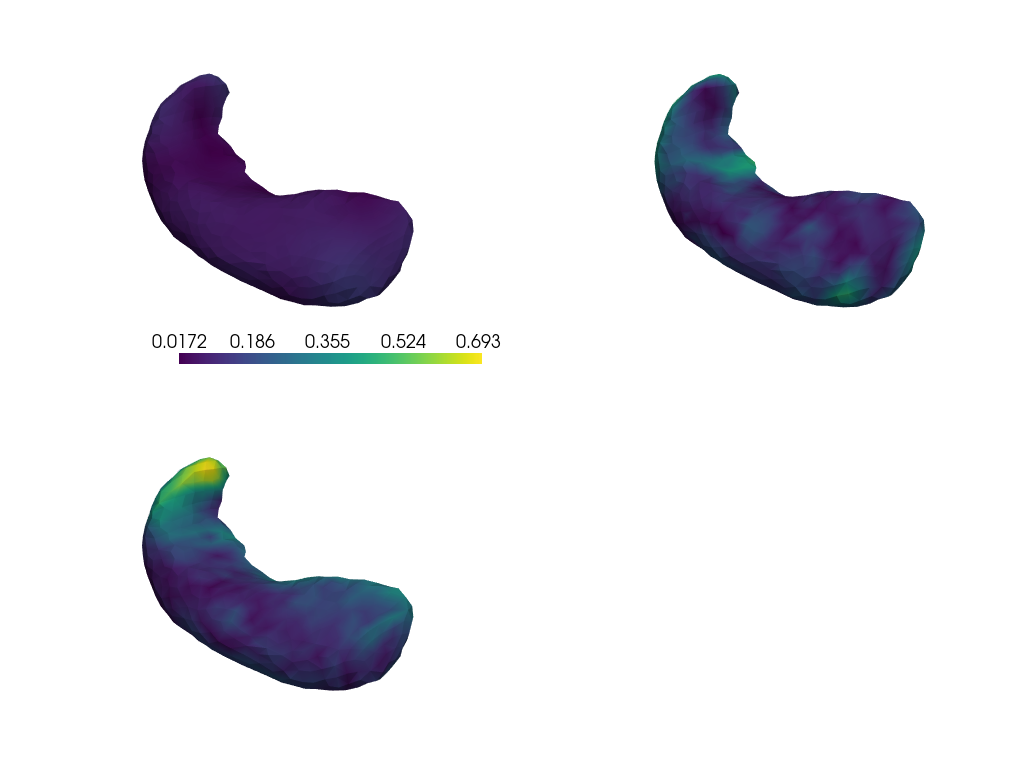

In [13]:
plot_shape = putils.plot_shape_from_n_plots(len(meshes), n_cols_max=2)

pl = pv.Plotter(shape=plot_shape, border=False)

# TODO: make this better after cleaning ids
for index, (mesh, rec_mesh) in enumerate(zip(meshes, rec_meshes.values())):
    pl.subplot(*putils.plot_index_to_shape(index, plot_shape[1]))

    # NB: assumes meshes are registered
    euc_res = np.linalg.norm(mesh.points - rec_mesh.points, axis=-1)
    pl.add_mesh(rec_mesh, scalars=euc_res)

pl.show()

Visualize the flow from the template to each of the meshes.

In [14]:
flows = plddmm.io.load_deterministic_atlas_flows(ATLAS_DIR, as_pv=True)

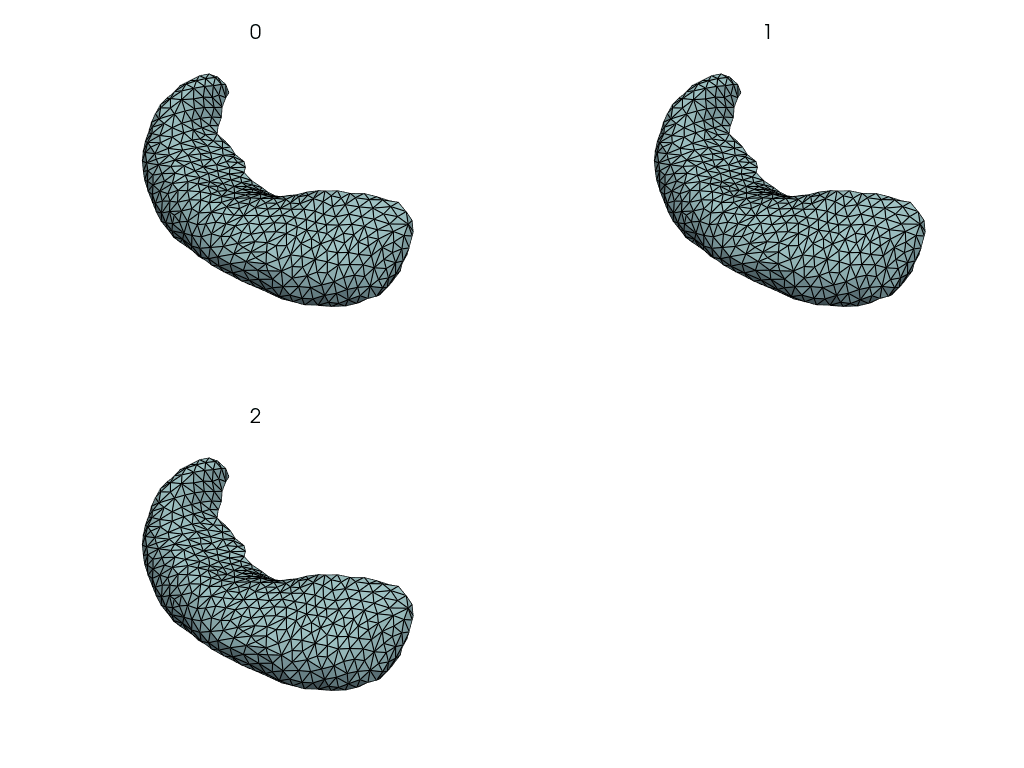

In [15]:
gif_dir = OUTPUTS_DIR / "_images"
gif_dir.mkdir(exist_ok=True)

gif_name = gif_dir / "flow.gif"


pl = RegisteredMeshesGifPlotter(
    shape=putils.plot_shape_from_n_plots(len(meshes), n_cols_max=2),
    gif_name=gif_name.as_posix(),
    fps=10,
    border=False,
    off_screen=True,
    notebook=False,
    subtitle=True,
)

pl.add_meshes(ppdict.DictListSwapper()(flows))
pl.close()

pl.show()